In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Import libraries
import tensorflow as tf
import keras
import numpy as np
import matplotlib.pyplot as plt
import os
from os import listdir
import cv2
import natsort
import tarfile
from sklearn.model_selection import train_test_split

# This line is important, without it the attacks in the ART toolbox won't work
# when using the Keras ART classifier
# And it needs to be run before training the models
tf.compat.v1.disable_eager_execution()

# Print the version of tensorflow and keras
print("TensorFlow version:{}".format(tf.__version__))
print("Keras version:{}".format(keras.__version__))

TensorFlow version:2.11.0
Keras version:2.11.0


In [ ]:
# Uncompress the Imagenette dataset 
# (Obviously, replace the path to the folder on Google drive where you saved the dataset)
tar = tarfile.open('drive/MyDrive/AML_Course/Assignment_1/imagenette2-160.tgz', 'r:gz')
for item in tar:
    tar.extract(item)

In [ ]:
# Function to load the images and the labels from the dataset
def load_images_and_labels(directory):

    imgs_list = []
    labels_list = []

    # List of all subfolders in the directory
    subfolders_list_1 = listdir(directory)
    # Make sure that the subfolders are sorted 
    subfolders_list = natsort.natsorted(subfolders_list_1)

    # Assign a label to each folder with images (0 to the first folder)
    lab = 0
    for subfolder_name in subfolders_list:
            sub_dir_path = directory + '/' + subfolder_name
            if subfolder_name != '.DS_Store':

                # Read the images as numpy arrays
                imagesList = listdir(sub_dir_path)
                for i in range(len(imagesList)):
                  tmp_img = cv2.imread(os.path.join(sub_dir_path, imagesList[i]))
                  # Resize all images to 128 x 128 pixels
                  resized_img = cv2.resize(tmp_img, (128, 128)) 
                  img_arr = np.array(resized_img)
                  imgs_list.append(img_arr/255.)
                  labels_list.append(lab)
                lab += 1
    
    # Convert the lists to numpy arrays
    imgs = np.asarray(imgs_list)
    labels = np.asarray(labels_list)

    return imgs, labels

# Use the above function to load the training and test datasets
train_images, train_labels = load_images_and_labels('imagenette2-160/train')
test_and_val_images, test_and_val_labels = load_images_and_labels('imagenette2-160/val')

In [ ]:
# Split into test and validation sets
test_images, val_images, test_labels, val_labels = train_test_split(test_and_val_images, test_and_val_labels, test_size=0.4, random_state=12)

In [ ]:
# Display the shapes of train, validation, and test datasets
print('Images train shape: {} - Labels train shape: {}'.format(train_images.shape, train_labels.shape))
print('Images validation shape: {} - Labels validation shape: {}'.format(val_images.shape, val_labels.shape))
print('Images test shape: {} - Labels test shape: {}'.format(test_images.shape, test_labels.shape))

# Display the range of images (to make sure they are in the [0, 1] range)
print('\nMax pixel value', np.max(train_images))
print('Min pixel value', np.min(train_images))
print('Average pixel value', np.mean(train_images))
print('Data type', train_images[0].dtype)

Images train shape: (9469, 128, 128, 3) - Labels train shape: (9469,)
Images validation shape: (1570, 128, 128, 3) - Labels validation shape: (1570,)
Images test shape: (2355, 128, 128, 3) - Labels test shape: (2355,)

Max pixel value 1.0
Min pixel value 0.0
Average pixel value 0.44966878195890436
Data type float64


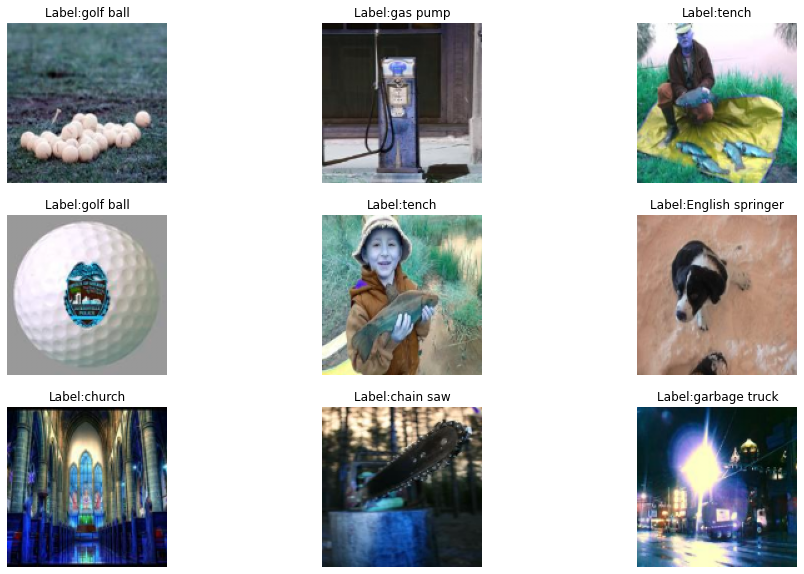

In [ ]:
# A list with the names of the image classes
label_names = ['tench', 'English springer', 'cassette player', 'chain saw', 'church', 'French horn',  'garbage truck', 'gas pump', 'golf ball', 'parachute']

# Plot a few images to check if the labels make sense
plt.figure(figsize=(16, 10))
for n in range(9):
    i = np.random.randint(0, len(train_images), 1)
    ax = plt.subplot(3, 3, n+1)
    plt.imshow(train_images[i[0]])
    plt.title('Label:' + str(label_names[train_labels[i[0]]]))
    plt.axis('off')

In [ ]:
NUM_CLASSES = 10

# Remember:
# 1. If you use one-hot vectors for the labels, the loss function in the model needs to be 'categorical_crossentropy'
# 2. If you use a single class value for the labels, the loss in the model needs to be 'sparse_categorical_crossentropy'

# If you wish to convert the labels into one-hot encoding (but you don't need to), use the following lines 
# from tensorflow.keras.utils import to_categorical
# train_labels_onehot = to_categorical(train_labels, NUM_CLASSES)
# val_labels_onehot = to_categorical(val_labels, NUM_CLASSES)
# test_labels_onehot = to_categorical(test_labels, NUM_CLASSES)

In [ ]:
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D, Dropout
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from keras.applications import vgg16
from tensorflow.keras.utils import to_categorical

import datetime
now = datetime.datetime.now

In [ ]:
base_model = vgg16.VGG16(weights='imagenet', include_top=False, input_shape=(128, 128, 3))

# Add a global spatial average pooling layer
x = base_model.output
x = GlobalAveragePooling2D()(x)
# Add fully-connected layers
x = Dense(2048, activation='relu')(x)
x = Dropout(0.25)(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.25)(x)
# Add a softmax layer with 10 classes
predictions = Dense(10, activation='softmax')(x)

# Create the model 
model = Model(inputs=base_model.input, outputs=predictions)

58889256/58889256 [==============================] - 0s 0us/step


In [ ]:
# Compile the model
model.compile(optimizer=Adam(learning_rate=1e-4), loss='sparse_categorical_crossentropy', metrics = ['accuracy'])

callbacks = [EarlyStopping(monitor='val_loss', patience=10)]

# Fit model
t = now()
history = model.fit(train_images, train_labels, epochs=100, batch_size=32,
                     validation_data=[val_images, val_labels], verbose=1, callbacks=callbacks)
print('Training time: %s' % (now() - t))

Train on 9469 samples, validate on 1570 samples
Epoch 1/100
9469/9469 [==============================] - ETA: 0s - loss: 0.8629 - accuracy: 0.7129

/usr/local/lib/python3.8/dist-packages/keras/engine/training_v1.py:2333: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


9469/9469 [==============================] - 57s 6ms/sample - loss: 0.8629 - accuracy: 0.7129 - val_loss: 0.4501 - val_accuracy: 0.8637
Epoch 2/100
9469/9469 [==============================] - 43s 5ms/sample - loss: 0.3592 - accuracy: 0.8906 - val_loss: 0.3552 - val_accuracy: 0.8764
Epoch 3/100
9469/9469 [==============================] - 43s 5ms/sample - loss: 0.2341 - accuracy: 0.9270 - val_loss: 0.3953 - val_accuracy: 0.8732
Epoch 4/100
9469/9469 [==============================] - 43s 5ms/sample - loss: 0.1601 - accuracy: 0.9521 - val_loss: 0.3843 - val_accuracy: 0.8777
Epoch 5/100
9469/9469 [==============================] - 43s 5ms/sample - loss: 0.1244 - accuracy: 0.9611 - val_loss: 0.3514 - val_accuracy: 0.8987
Epoch 6/100
9469/9469 [==============================] - 43s 5ms/sample - loss: 0.1027 - accuracy: 0.9682 - val_loss: 0.4447 - val_accuracy: 0.8917
Epoch 7/100
9469/9469 [==============================] - 43s 5ms/sample - loss: 0.0836 - accuracy: 0.9766 - val_loss: 0.4717

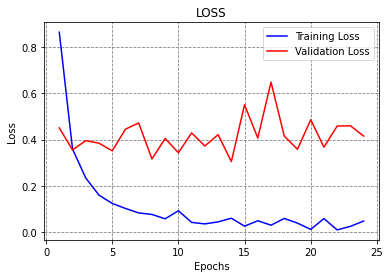

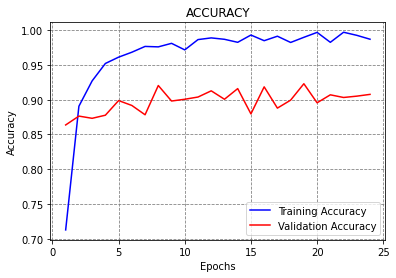

In [ ]:
# Plot the loss and accuracy
train_loss = history.history['loss']
val_loss = history.history['val_loss']
acc = history.history['accuracy'] 
val_acc = history.history['val_accuracy']

epochsn = np.arange(1, len(train_loss)+1,1)
plt.plot(epochsn,train_loss, 'b', label='Training Loss')
plt.plot(epochsn,val_loss, 'r', label='Validation Loss')
plt.grid(color='gray', linestyle='--')
plt.legend()
plt.title('LOSS')
plt.xlabel('Epochs')
plt.ylabel('Loss')

plt.figure()
plt.plot(epochsn, acc, 'b', label='Training Accuracy')
plt.plot(epochsn, val_acc, 'r', label='Validation Accuracy')
plt.grid(color='gray', linestyle='--')
plt.legend()            
plt.title('ACCURACY')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.show() 

In [ ]:
# Evaluate on test images
evals_test = model.evaluate(test_images, test_labels)
print("Classification Accuracy: ", evals_test[1])

Classification Accuracy:  0.91082805


# Non-targeted Adversarial Attacks

In [ ]:
pip install adversarial-robustness-toolbox

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 18.6 MB/s eta 0:00:00


In [ ]:
if tf.__version__[0] != '2':
    raise ImportError('This notebook requires Tensorflow v2.')

In [ ]:
from art.estimators.classification import KerasClassifier
from art.attacks.evasion import FastGradientMethod, ProjectedGradientDescent

In [ ]:
classifier = KerasClassifier(model=model, clip_values=(0, 1), use_logits=True)

/usr/local/lib/python3.8/dist-packages/keras/backend.py:5585: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


In [ ]:
# Use the first 200 test images for creating adversarial samples
adv_imgs = test_images[0:200]
adv_labels = test_labels[0:200]

/usr/local/lib/python3.8/dist-packages/keras/engine/training_v1.py:2357: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


Accuracy on adversarial test data: 90.00%
Average perturbation: 0.00


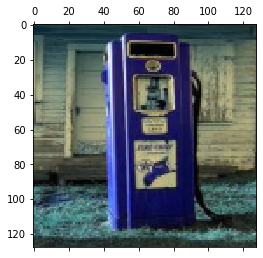

Accuracy on adversarial test data: 83.50%
Average perturbation: 0.00


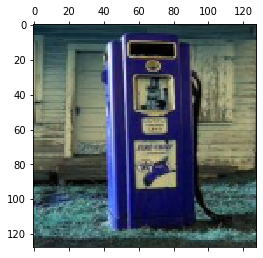

Accuracy on adversarial test data: 57.50%
Average perturbation: 0.01


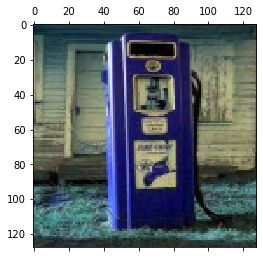

Accuracy on adversarial test data: 44.50%
Average perturbation: 0.02


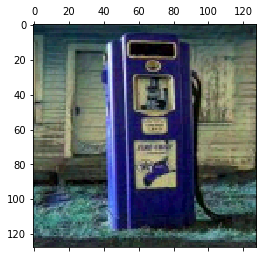

Accuracy on adversarial test data: 40.50%
Average perturbation: 0.03


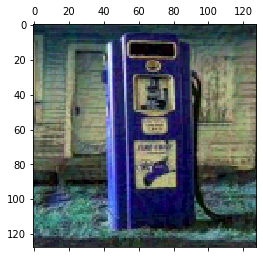

Accuracy on adversarial test data: 38.00%
Average perturbation: 0.07


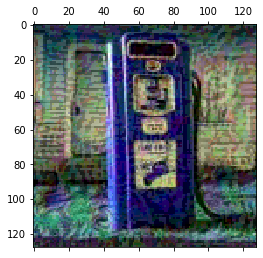

Accuracy on adversarial test data: 29.50%
Average perturbation: 0.18


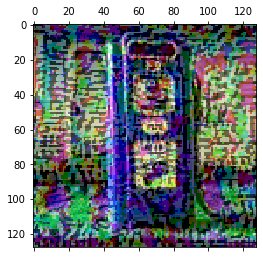

Accuracy on adversarial test data: 17.50%
Average perturbation: 0.26


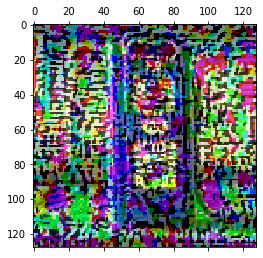

In [ ]:
# FGSM attack
epsilon = [0./255, 1./255, 3./255, 5./255, 8./255, 20./255, 50./255, 80./255]

fgsm_attack_acc = []
for eps in epsilon:
    attack_fgsm = FastGradientMethod(estimator=classifier, eps=eps)
    fgsm_attack_adv_imgs = attack_fgsm.generate(adv_imgs)
    loss_test, accuracy_test = model.evaluate(fgsm_attack_adv_imgs, adv_labels)
    fgsm_attack_acc.append(accuracy_test)
    perturbation = np.mean(np.abs((fgsm_attack_adv_imgs - adv_imgs)))
    print('Accuracy on adversarial test data: {:4.2f}%'.format(accuracy_test * 100))
    print('Average perturbation: {:4.2f}'.format(perturbation))
    plt.matshow(np.squeeze(fgsm_attack_adv_imgs[0]))
    plt.show()

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Accuracy on adversarial test data: 90.00%
Average perturbation: 0.00


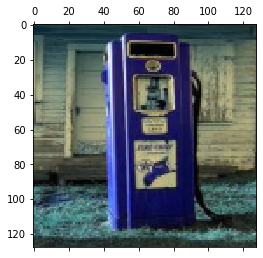

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Accuracy on adversarial test data: 80.50%
Average perturbation: 0.00


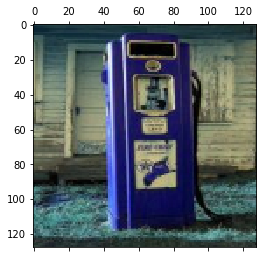

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Accuracy on adversarial test data: 47.00%
Average perturbation: 0.01


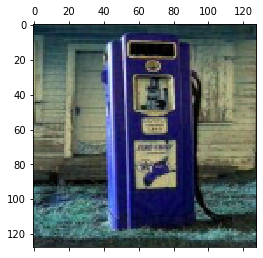

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Accuracy on adversarial test data: 38.00%
Average perturbation: 0.02


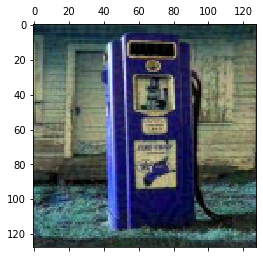

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Accuracy on adversarial test data: 30.00%
Average perturbation: 0.03


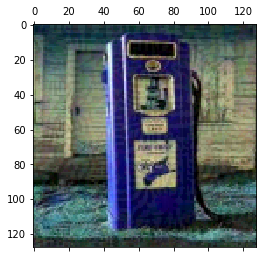

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Accuracy on adversarial test data: 15.00%
Average perturbation: 0.06


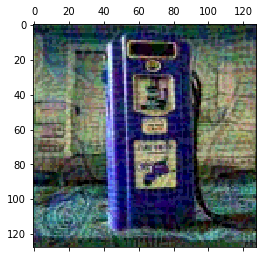

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Accuracy on adversarial test data: 14.00%
Average perturbation: 0.13


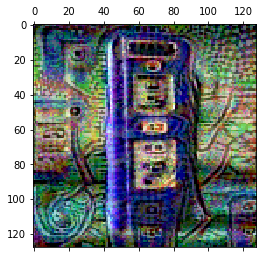

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Accuracy on adversarial test data: 17.50%
Average perturbation: 0.19


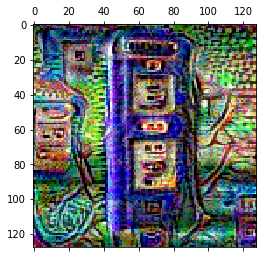

In [ ]:
# PGD attack

pgd_attack_acc = []
for eps in epsilon:
    attack_pgd = ProjectedGradientDescent(estimator=classifier, eps=eps)
    pgd_attack_adv_imgs = attack_pgd.generate(adv_imgs)
    loss_test, accuracy_test = model.evaluate(pgd_attack_adv_imgs, adv_labels)
    pgd_attack_acc.append(accuracy_test)
    perturbation = np.mean(np.abs((pgd_attack_adv_imgs - adv_imgs)))
    print('Accuracy on adversarial test data: {:4.2f}%'.format(accuracy_test * 100))
    print('Average perturbation: {:4.2f}'.format(perturbation))
    plt.matshow(np.squeeze(pgd_attack_adv_imgs[0]))
    plt.show()

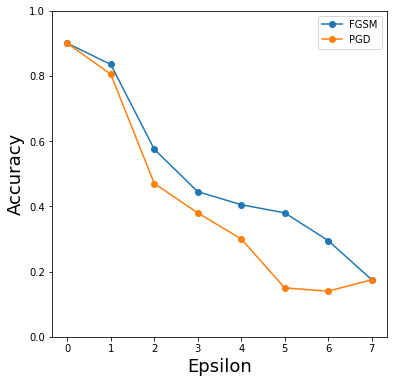

In [ ]:
# Plot the success rate of FGSM and PGD attacks
attack_name = ['FGSM', 'PGD']
attack_acc = [fgsm_attack_acc, pgd_attack_acc]

plt.figure(figsize=(6,6))
plt.ylim(0, 1)
plt.xlabel('Epsilon', fontsize=18)
plt.ylabel('Accuracy', fontsize=18)
for i in range(len(attack_name)):
    plt.plot(attack_acc[i], marker='o', label=attack_name[i])
plt.legend(loc='upper right')
plt.show()

Perturbation maginutude: 0.0039
Predicted label: garbage truck


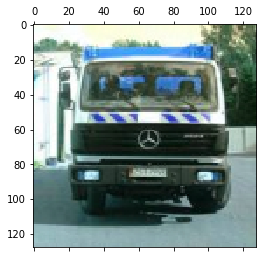

Perturbation maginutude: 0.0196
Predicted label: cassette player


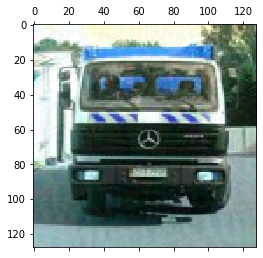

Perturbation maginutude: 0.0314
Predicted label: cassette player


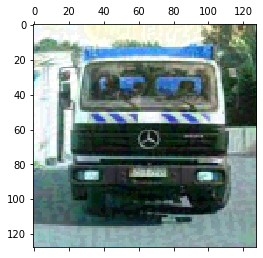

Perturbation maginutude: 0.1961
Predicted label: church


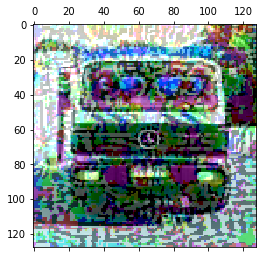

Perturbation maginutude: 0.3137
Predicted label: church


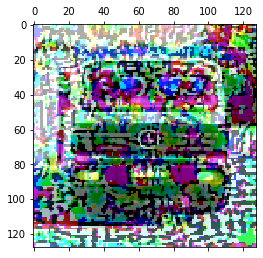

In [ ]:
# Plot figures for the FGSM attack
epsilon1 = [1./255, 5./255, 8./255, 50./255, 80./255]

for eps in epsilon1:
    attack_fgsm = FastGradientMethod(estimator=classifier, eps=eps)
    fgsm_attack_adv_imgs = attack_fgsm.generate(adv_imgs[3:4])
    print('Perturbation maginutude: {:5.4f}'.format(eps))
    preds = model.predict(fgsm_attack_adv_imgs)
    print('Predicted label:', str(label_names[np.argmax(preds[0], axis=-1)]))
    plt.matshow(np.squeeze(fgsm_attack_adv_imgs[0]))
    plt.show()

# Targeted Adversarial Attack

In [ ]:
# Collect all "Church" images from the dataset
church_images_list = []
for i, label in enumerate(test_labels):
  if label==4:
      church_images_list.append(test_images[i])

church_images = np.asarray(church_images_list)

print(church_images.shape)

(249, 128, 128, 3)


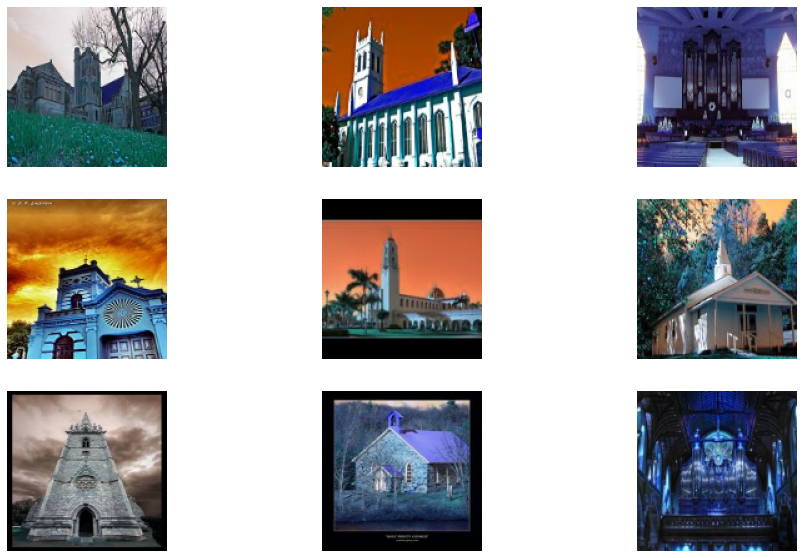

In [ ]:
# Plot a few images to check if the labels are accurate
plt.figure(figsize=(16, 10))
for n in range(9):
    i = np.random.randint(0, len(church_images), 1)
    ax = plt.subplot(3, 3, n+1)
    plt.imshow(church_images[i[0]])
    plt.axis('off')

In [ ]:
# Target labels are "Gas pump" (class label is 7)
labels_target = 7*np.ones((len(church_images),1))

In [ ]:
labels_target.shape

(249, 1)

In [ ]:
# Church labels
labels_church = 4*np.ones((len(church_images),1))

In [ ]:
# Evaluate the accuracy of the model on the set of church images
loss_test, accuracy_test = model.evaluate(np.array(church_images), labels_church)
print('Accuracy on clean test data: {:4.2f}%'.format(accuracy_test * 100))

Accuracy on clean test data: 93.98%


Accuracy on adversarial test data: 0.80%
Average perturbation: 0.00
Predicted class: [4 4 4 4 4 4 4 4 4 4 4 4 6 4 4 4 4 4 9 4 6 4 4 4 4 4 4 6 4 4 4 4 4 4 4 4 4
 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 3 4 4
 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 3 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4
 4 4 4 1 4 4 4 4 4 4 4 4 4 4 4 4 4 4 7 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4
 4 4 4 4 4 5 4 4 4 4 5 4 4 4 4 4 9 4 7 4 4 6 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4
 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 3 4 4 4 4 4 4 4
 4 4 4 4 4 4 3 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4]
Accuracy on church labels: 93.98%
Predicted as target labels: 0.80%


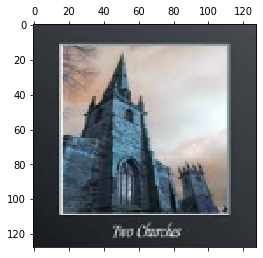

Accuracy on adversarial test data: 5.62%
Average perturbation: 0.00
Predicted class: [4 4 4 4 4 4 9 9 4 4 4 4 4 4 4 4 4 4 4 4 6 4 4 4 4 4 4 4 4 3 4 4 1 4 4 4 0
 4 9 4 4 6 4 4 4 4 4 4 9 4 4 4 9 4 4 4 4 4 6 6 4 4 4 4 4 8 4 6 9 4 4 6 4 6
 4 8 3 4 4 6 4 9 4 6 4 4 7 4 4 7 2 4 4 4 4 4 4 4 4 6 4 4 7 4 3 4 4 4 4 7 4
 4 4 4 4 4 4 4 7 4 4 4 4 4 4 4 1 4 4 7 4 1 4 4 4 4 4 4 6 4 4 4 4 6 4 3 4 9
 4 6 4 4 4 5 4 6 4 4 4 4 4 4 4 4 7 7 7 4 6 3 4 4 4 4 4 4 6 4 4 4 4 4 6 4 7
 4 4 4 4 4 4 3 4 4 4 4 7 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 7 4 4 4 4 4 8 4
 4 4 4 4 6 1 6 4 4 6 4 4 4 4 7 4 3 6 4 7 4 4 4 4 4 4 4]
Accuracy on church labels: 75.90%
Predicted as target labels: 5.62%


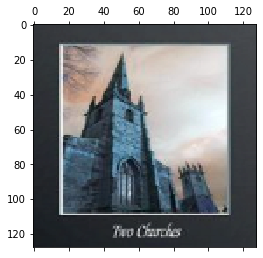

Accuracy on adversarial test data: 11.24%
Average perturbation: 0.01
Predicted class: [4 5 6 6 1 7 9 9 4 4 6 4 4 9 4 7 3 4 4 4 7 4 4 1 4 4 4 4 4 3 4 4 1 1 9 4 1
 4 6 4 4 6 4 3 4 4 6 4 9 4 4 6 9 4 4 4 6 6 6 6 3 6 3 4 6 8 4 6 9 6 6 6 4 6
 4 8 3 7 4 6 4 7 4 6 6 4 7 4 7 7 2 7 4 4 4 2 4 5 4 6 4 4 7 4 3 4 4 4 4 7 3
 9 1 4 4 6 4 6 7 4 4 5 4 6 4 4 1 4 4 7 4 1 4 6 4 3 4 4 6 3 9 9 4 6 5 3 4 3
 4 6 4 4 4 7 4 6 7 5 7 4 4 4 9 7 7 7 7 4 6 3 6 6 6 4 4 4 6 4 5 9 3 4 6 4 7
 7 4 9 5 7 3 3 4 4 7 3 7 4 7 3 5 9 4 4 4 4 4 4 5 5 4 4 4 2 7 4 4 2 4 4 8 4
 4 3 4 4 6 1 6 4 4 6 4 4 4 4 7 4 3 6 2 5 4 4 1 4 4 4 8]
Accuracy on church labels: 46.99%
Predicted as target labels: 11.24%


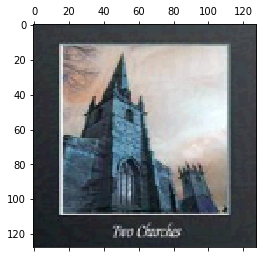

Accuracy on adversarial test data: 18.07%
Average perturbation: 0.02
Predicted class: [4 5 6 3 1 7 9 9 4 4 6 4 4 9 5 7 3 2 4 4 7 4 4 1 3 5 4 4 4 3 4 6 1 7 9 2 1
 5 6 4 1 2 7 7 3 7 6 9 9 4 6 7 9 9 9 4 6 6 6 6 3 6 3 5 6 8 7 6 9 6 6 6 9 1
 4 8 3 7 9 6 4 7 4 6 6 7 7 4 7 7 2 7 4 4 7 2 4 5 7 6 4 4 7 5 3 4 7 6 9 7 3
 9 1 4 4 6 9 6 7 4 4 1 7 6 4 6 1 4 9 7 9 1 4 6 6 3 5 4 6 3 9 9 9 6 5 3 4 3
 4 6 4 4 9 7 4 6 7 5 7 7 8 4 9 7 7 7 7 4 6 3 6 6 6 3 4 4 6 4 5 9 3 3 6 4 7
 7 4 9 5 7 3 3 1 4 7 3 7 4 7 3 7 9 4 4 4 4 7 4 5 5 6 4 4 2 7 4 9 2 6 4 8 4
 0 3 7 4 6 1 6 9 6 6 4 4 4 4 7 4 3 6 2 7 4 9 1 9 7 4 8]
Accuracy on church labels: 26.51%
Predicted as target labels: 18.07%


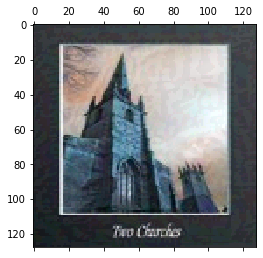

Accuracy on adversarial test data: 21.29%
Average perturbation: 0.03
Predicted class: [4 5 6 3 1 7 9 9 4 4 1 4 4 9 5 7 3 2 4 4 7 7 4 1 3 6 4 4 1 3 9 6 1 7 9 2 1
 5 6 9 1 2 7 7 3 7 3 9 9 5 6 3 9 9 9 4 6 6 6 6 3 3 3 5 3 8 7 6 9 6 6 6 9 1
 7 8 3 7 9 3 4 7 5 6 6 7 7 9 7 7 2 7 5 3 7 2 7 5 7 6 7 1 7 5 3 3 7 3 5 7 3
 9 5 4 4 6 3 7 7 4 4 1 7 6 4 8 1 1 9 7 9 1 4 6 6 3 5 4 6 3 9 9 9 6 5 3 4 3
 6 6 4 4 1 7 1 6 7 5 7 7 8 1 9 2 7 7 7 4 6 3 6 6 6 3 4 7 6 5 5 9 3 3 6 4 7
 7 4 9 9 7 3 3 1 4 7 3 7 7 7 3 7 9 7 4 5 4 7 4 5 5 6 3 4 2 7 9 9 2 6 4 8 3
 0 3 7 4 6 1 7 9 6 6 4 1 4 3 7 1 3 6 2 7 4 3 1 9 7 7 8]
Accuracy on church labels: 14.46%
Predicted as target labels: 21.29%


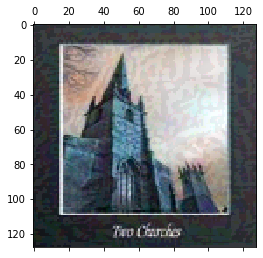

Accuracy on adversarial test data: 17.67%
Average perturbation: 0.07
Predicted class: [4 5 6 3 3 9 9 8 4 9 3 9 4 9 8 7 3 2 4 3 8 7 5 1 3 5 6 4 4 3 9 7 1 3 9 2 1
 5 6 5 1 3 6 7 3 7 3 4 9 5 4 3 9 3 4 9 6 3 6 3 5 3 3 5 9 3 7 6 9 6 6 6 5 1
 7 8 3 7 9 3 6 7 5 3 6 7 3 9 3 7 2 3 3 3 7 2 7 5 4 6 7 4 7 5 3 4 7 6 5 7 3
 9 5 4 4 2 3 7 4 4 1 5 7 6 4 8 4 4 9 7 9 5 4 6 6 3 5 4 5 3 3 9 9 6 5 3 4 3
 6 7 3 3 3 7 7 3 7 5 7 6 8 4 9 8 5 7 7 5 6 3 9 6 3 3 4 7 6 5 5 3 3 3 5 0 7
 7 3 9 9 7 3 3 1 4 7 3 7 7 8 3 3 8 7 4 5 4 7 9 5 5 6 3 3 4 7 9 9 7 6 4 8 3
 0 3 7 3 6 7 4 9 6 6 3 1 3 3 7 1 3 3 3 7 7 3 3 9 4 7 3]
Accuracy on church labels: 12.45%
Predicted as target labels: 17.67%


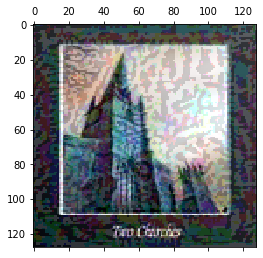

Accuracy on adversarial test data: 3.61%
Average perturbation: 0.17
Predicted class: [4 4 4 3 4 4 9 5 4 4 4 4 4 9 4 4 4 4 4 4 9 4 4 4 3 4 3 4 4 4 4 4 4 4 4 4 3
 4 4 4 4 4 4 9 4 7 4 4 9 3 4 4 4 4 4 4 4 4 9 4 5 4 3 5 9 4 4 4 4 4 4 4 5 4
 4 9 4 4 4 4 4 4 4 4 4 4 4 9 4 7 4 4 4 3 4 4 4 4 4 4 4 4 4 4 4 4 7 5 4 5 9
 4 4 4 4 4 9 7 4 4 4 4 4 4 4 4 4 4 9 7 3 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4
 4 4 4 4 4 4 4 5 4 4 4 4 4 4 4 4 4 4 4 4 4 3 9 6 9 4 4 4 4 4 5 3 5 4 4 4 4
 7 3 4 9 7 4 3 3 4 4 4 9 4 3 4 4 4 4 4 4 4 7 4 5 4 4 4 4 4 4 4 9 5 4 4 4 4
 4 3 4 3 4 4 4 9 4 4 5 4 4 4 4 4 3 3 4 5 7 9 4 4 4 4 4]
Accuracy on church labels: 75.90%
Predicted as target labels: 3.61%


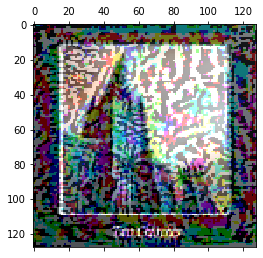

Accuracy on adversarial test data: 0.00%
Average perturbation: 0.26
Predicted class: [4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4
 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4
 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 3 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 9 9
 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4
 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4
 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 5 4 4 4 4 4 4 4 4 4 4 4 4 4
 4 4 4 4 4 4 4 9 4 4 4 4 4 4 4 4 3 5 4 4 4 4 4 4 4 4 4]
Accuracy on church labels: 97.19%
Predicted as target labels: 0.00%


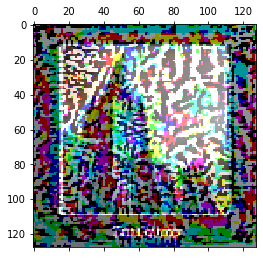

In [ ]:
# FGSM targetted attack

epsilon = [0./255, 1./255, 3./255, 5./255, 8./255, 20./255, 50./255, 80./255]

fgsm_target_attack_acc = []

for eps in epsilon:
    attack_fgsm_tar = FastGradientMethod(estimator=classifier, eps=eps, targeted=True)
    fgsm_attack_adv_imgs_tar = attack_fgsm_tar.generate(church_images, labels_target)
    loss_test, accuracy_test = model.evaluate(fgsm_attack_adv_imgs_tar, labels_target)
    fgsm_target_attack_acc.append(accuracy_test)
    perturbation = np.mean(np.abs((fgsm_attack_adv_imgs_tar - church_images)))
    print('Accuracy on adversarial test data: {:4.2f}%'.format(accuracy_test * 100))
    print('Average perturbation: {:4.2f}'.format(perturbation))

    preds = model.predict(fgsm_attack_adv_imgs_tar)
    print('Predicted class:', np.argmax(preds, axis=-1))

    loss_test, accuracy_test = model.evaluate(fgsm_attack_adv_imgs_tar, labels_church)
    print('Accuracy on church labels: {:4.2f}%'.format(accuracy_test * 100))

    print('Predicted as target labels: {:4.2f}%'.format(100*np.sum(np.argmax(preds, axis=-1)==7)/len(labels_target)))

    plt.matshow(np.squeeze(fgsm_attack_adv_imgs_tar[0]))
    plt.show()

Accuracy on adversarial test data: 0.80%
Average perturbation: 0.00
Predicted class: [4 4 4 4 4 4 4 4 4 4 4 4 6 4 4 4 4 4 9 4 6 4 4 4 4 4 4 6 4 4 4 4 4 4 4 4 4
 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 3 4 4
 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 3 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4
 4 4 4 1 4 4 4 4 4 4 4 4 4 4 4 4 4 4 7 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4
 4 4 4 4 4 5 4 4 4 4 5 4 4 4 4 4 9 4 7 4 4 6 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4
 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 3 4 4 4 4 4 4 4
 4 4 4 4 4 4 3 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4]
Accuracy on church labels: 93.98%
Predicted as target labels: 0.80%
**********


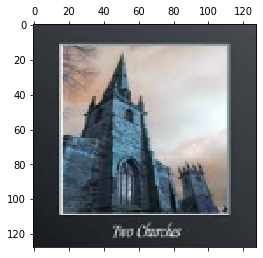

Accuracy on adversarial test data: 5.62%
Average perturbation: 0.00
Predicted class: [4 4 4 4 4 4 4 4 4 4 4 4 6 4 4 4 4 4 9 4 4 4 4 4 4 4 4 6 4 4 4 4 4 4 4 4 4
 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 3 4 4
 4 4 3 4 4 6 4 4 4 6 4 4 7 4 4 7 4 4 4 4 4 4 4 4 4 6 4 4 7 4 4 4 4 4 4 7 4
 4 4 4 1 4 4 4 7 4 4 4 4 4 4 4 4 4 4 7 4 4 4 4 4 4 4 4 4 4 4 4 4 6 4 4 4 4
 4 4 4 4 4 5 4 4 7 4 5 4 4 4 4 4 6 7 7 4 4 6 4 4 4 4 4 4 4 4 4 4 4 4 6 4 7
 4 4 4 4 4 4 4 4 4 4 4 7 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 7 4 4 4 4 4 4 4
 4 4 4 4 4 4 3 4 4 4 4 4 4 4 7 4 4 4 4 7 4 4 4 4 4 4 4]
Accuracy on church labels: 87.95%
Predicted as target labels: 5.62%
**********


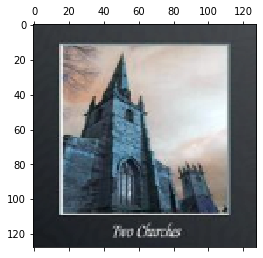

Accuracy on adversarial test data: 14.06%
Average perturbation: 0.01
Predicted class: [4 4 6 4 4 4 4 9 4 4 4 4 7 4 4 4 4 4 6 4 6 4 4 4 4 4 4 4 4 3 4 4 4 4 4 4 4
 4 4 4 4 9 4 4 4 4 7 4 4 4 4 4 4 4 4 4 4 4 4 6 4 4 4 4 4 4 4 4 4 6 4 4 4 4
 4 8 7 7 4 4 4 7 4 4 6 4 7 4 7 7 4 7 4 4 4 4 4 5 4 4 4 4 7 4 4 4 4 6 4 7 4
 4 4 4 1 4 4 7 7 4 4 7 7 6 4 4 1 4 4 7 4 4 4 7 4 3 4 4 7 4 4 4 4 4 4 4 4 3
 4 4 4 4 4 7 4 4 7 4 7 4 4 4 4 7 6 4 7 4 4 3 4 4 4 4 4 7 4 4 4 4 4 4 4 4 7
 7 4 4 4 7 4 4 4 4 7 4 7 4 7 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 7 4 4 4 6 4 4 4
 4 4 7 4 4 4 7 4 4 4 4 4 4 4 7 4 4 6 4 7 4 4 4 4 4 4 4]
Accuracy on church labels: 77.51%
Predicted as target labels: 14.06%
**********


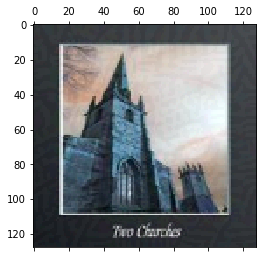

Accuracy on adversarial test data: 24.10%
Average perturbation: 0.02
Predicted class: [4 7 6 4 4 4 4 8 4 4 3 4 6 4 4 7 4 4 4 4 6 4 4 4 4 7 4 7 4 7 4 7 4 4 4 4 4
 4 6 4 4 0 4 4 7 7 7 4 4 4 4 4 4 4 4 4 4 4 4 7 4 1 4 4 3 4 7 7 4 4 6 3 4 4
 4 4 4 7 4 7 4 7 6 7 4 4 7 4 4 7 2 4 4 4 7 4 7 4 4 6 4 4 7 4 4 4 7 6 4 7 4
 4 4 4 1 7 3 7 4 4 4 4 7 4 4 4 4 4 4 7 4 7 4 4 4 4 4 4 4 4 4 4 7 4 4 4 4 4
 7 7 4 4 4 7 4 7 7 4 7 4 3 4 4 4 7 7 7 4 4 3 4 4 7 4 4 4 4 4 4 3 4 3 7 4 7
 7 4 4 9 7 4 7 1 4 7 4 7 4 4 4 4 7 4 4 4 4 7 4 4 7 5 4 4 4 7 4 4 4 4 4 4 4
 4 4 7 4 7 7 7 4 4 4 4 4 4 4 7 7 4 6 7 7 4 4 4 4 4 7 7]
Accuracy on church labels: 65.86%
Predicted as target labels: 24.10%
**********


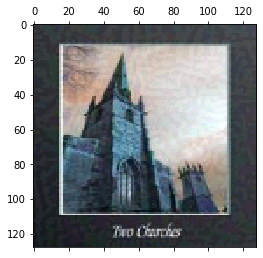

Accuracy on adversarial test data: 32.13%
Average perturbation: 0.03
Predicted class: [4 4 4 4 4 4 4 4 4 4 6 4 7 4 4 7 4 4 1 4 7 4 4 4 7 4 4 7 4 7 7 7 4 4 4 4 7
 4 6 4 7 8 4 7 7 7 7 4 7 4 4 7 4 4 4 7 4 4 4 7 7 4 3 4 4 4 7 7 1 4 4 7 4 4
 4 7 3 7 3 7 4 7 4 7 3 4 4 4 4 7 4 4 4 4 7 4 4 4 7 5 7 4 7 4 7 3 7 6 4 4 4
 7 4 4 7 7 6 7 7 4 4 4 4 4 4 4 4 4 9 7 4 4 4 4 4 7 4 4 4 4 4 4 7 7 4 7 4 4
 4 7 4 4 4 7 4 7 7 4 7 4 4 4 4 4 7 7 7 4 7 3 4 4 7 4 7 7 7 4 4 3 7 4 7 4 7
 7 4 4 4 7 7 7 4 4 7 4 7 4 4 4 4 4 7 4 7 4 7 4 5 7 4 4 4 4 4 4 4 7 4 4 4 4
 4 4 7 4 7 7 7 4 4 6 4 7 4 4 7 4 4 4 7 7 4 8 4 4 4 4 7]
Accuracy on church labels: 60.24%
Predicted as target labels: 32.13%
**********


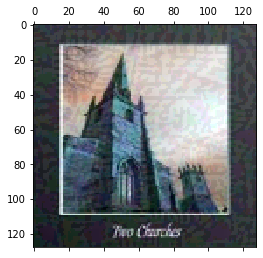

Accuracy on adversarial test data: 85.54%
Average perturbation: 0.06
Predicted class: [7 7 6 7 7 7 7 7 7 7 3 8 7 7 7 7 7 7 7 7 7 3 7 7 5 7 7 7 7 7 7 7 7 7 7 4 7
 7 7 4 7 7 7 7 3 7 4 7 7 7 7 7 7 7 7 7 8 7 7 7 7 7 7 7 7 7 7 7 7 7 5 7 7 7
 7 9 7 3 7 7 7 7 4 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 4 7 7 7 7 7 7 7 7 7 7
 7 0 7 7 7 7 7 7 7 7 7 7 7 7 4 7 7 7 7 7 7 7 7 4 7 7 7 7 9 7 7 7 7 7 7 7 7
 7 7 7 7 7 4 4 7 4 5 7 7 7 7 7 7 7 7 7 7 7 7 7 5 7 7 7 7 7 7 7 7 7 7 7 7 7
 7 7 7 7 7 7 4 7 7 7 7 7 7 8 7 7 7 7 5 7 8 7 7 7 7 7 3 7 4 7 7 7 7 7 5 7 7
 7 7 7 7 7 3 7 7 7 4 7 7 7 7 7 1 7 7 7 7 4 4 7 7 7 7 7]
Accuracy on church labels: 6.02%
Predicted as target labels: 85.54%
**********


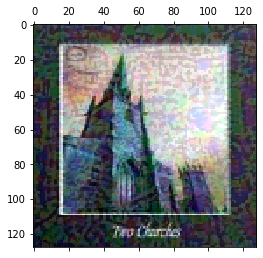

Accuracy on adversarial test data: 56.22%
Average perturbation: 0.11
Predicted class: [7 7 7 7 7 7 4 7 7 7 4 9 4 7 7 7 4 7 5 7 8 3 5 7 7 5 7 5 7 7 7 5 4 7 7 4 7
 5 4 7 7 5 7 9 7 5 4 7 4 7 7 7 7 4 4 7 9 7 7 4 3 7 5 7 9 4 4 7 5 7 5 7 7 7
 7 7 7 7 5 5 8 7 7 4 3 7 7 7 4 7 7 7 7 4 5 7 7 5 7 5 7 5 7 7 7 7 4 7 7 5 3
 3 4 7 4 7 5 7 7 7 5 7 4 7 4 7 7 7 4 7 7 7 7 7 5 7 7 3 7 7 4 4 7 9 7 4 5 4
 7 7 7 7 7 7 4 9 4 5 3 7 9 7 5 7 7 5 3 4 4 4 7 3 5 7 7 7 4 3 7 4 5 7 7 4 4
 5 7 7 9 7 4 4 4 7 5 4 7 6 4 5 7 7 7 7 7 4 7 4 4 7 7 8 7 4 4 7 7 7 7 4 4 7
 7 7 7 5 7 7 3 7 4 4 3 7 7 7 7 7 4 7 7 4 7 7 4 7 7 4 7]
Accuracy on church labels: 21.69%
Predicted as target labels: 56.22%
**********


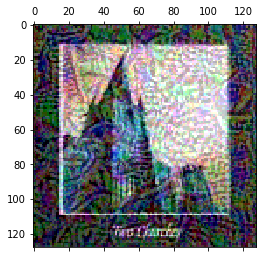

Accuracy on adversarial test data: 70.28%
Average perturbation: 0.17
Predicted class: [7 7 4 4 9 4 7 7 7 7 7 7 7 7 7 7 7 7 7 7 4 7 7 7 7 7 7 4 7 7 7 7 4 7 7 7 7
 7 7 7 7 4 7 7 7 7 4 7 9 4 7 7 7 7 7 7 7 7 9 7 7 4 7 7 7 7 7 4 7 4 7 7 7 7
 7 7 4 7 4 4 4 9 4 7 7 7 4 4 7 4 7 7 5 5 7 4 7 7 9 7 7 7 4 7 7 4 7 7 7 7 7
 7 7 5 7 4 9 7 7 9 4 7 4 7 7 7 4 4 7 7 4 7 7 4 7 7 7 7 7 4 7 7 7 4 9 7 7 7
 4 5 4 7 7 7 7 5 7 7 7 7 7 7 4 7 7 7 9 7 7 7 7 7 7 7 7 4 7 4 4 7 7 7 4 4 4
 7 7 7 7 5 7 7 4 7 7 4 4 7 7 7 7 7 7 4 7 7 7 7 7 4 7 7 4 7 7 7 7 7 4 7 7 7
 4 7 4 7 7 4 4 7 7 7 7 7 7 7 7 4 7 4 7 7 9 4 4 4 4 7 7]
Accuracy on church labels: 23.29%
Predicted as target labels: 70.28%
**********


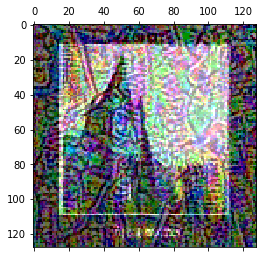

Training time: 0:45:31.678112


In [ ]:
# PGD targetted attack

pgd_target_attack_acc = []
for eps in epsilon:
    attack_pgd_tar = ProjectedGradientDescent(estimator=classifier, eps=eps, targeted=True, verbose=False)
    pgd_attack_adv_imgs_tar = attack_pgd_tar.generate(church_images, labels_target)
    loss_test, accuracy_test = model.evaluate(pgd_attack_adv_imgs_tar, labels_target)
    pgd_target_attack_acc.append(accuracy_test)
    perturbation = np.mean(np.abs((pgd_attack_adv_imgs_tar - church_images)))
    
    print('Accuracy on adversarial test data: {:4.2f}%'.format(accuracy_test * 100))
    print('Average perturbation: {:4.2f}'.format(perturbation))

    preds = model.predict(pgd_attack_adv_imgs_tar)
    print('Predicted class:', np.argmax(preds, axis=-1))

    loss_test, accuracy_test = model.evaluate(pgd_attack_adv_imgs_tar, labels_church)
    print('Accuracy on church labels: {:4.2f}%'.format(accuracy_test * 100))

    print('Predicted as target labels: {:4.2f}%'.format(100*np.sum(np.argmax(preds, axis=-1)==7)/len(labels_target)))

    print(10*'*')

    plt.matshow(np.squeeze(pgd_attack_adv_imgs_tar[0]))
    plt.show()

print('Training time: %s' % (now() - t))